In [2]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch
import torch.functional as f
import math

In [10]:
from ale_py import ALEInterface
ale = ALEInterface()

In [11]:
from ale_py.roms import Skiing
ale.loadROM(Skiing)

In [12]:
from typing import Any, Text

from ale_py.env import gym as ale_gym

# Patch to allow rendering Atari games.
# The AtariEnv's render method expects the mode to be in self._render_mode
# (usually initialized with env.make) instead of taking mode as a param.
_original_atari_render = ale_gym.AtariEnv.render


def atari_render(self, mode: Text = 'rgb_array') -> Any:
  original_render_mode = self._render_mode
  try:
    self._render_mode = mode
    return _original_atari_render(self)
  finally:
    self._render_mode = original_render_mode


ale_gym.AtariEnv.render = atari_render

In [13]:
env = gym.make('ALE/Skiing-v5')

In [6]:
def epsilon_greedy_policy(state, Q, epsilon, n_action):
  probs = torch.ones(n_action) * epsilon / n_action
  best_action = torch.argmax(Q[state]).item()
  probs[best_action] += 1.0 - epsilon
  return torch.multinomial(probs, 1).item()

# def epsilon_greedy_policy(observation, Q, epsilon, n_action):
#   A = np.ones(n_action, dtype=int) * epsilon / n_action
#   best_action = np.argmax(Q[observation])
#   A[best_action] += (1.0 - epsilon)
#   return A

In [5]:
def get_pos_player(observe):
    ids = np.where(np.sum(observe == [214, 92, 92], -1) == 3)
    if len(ids[0]) == 0:
        return 0, 0  
    else:
        return int(ids[0].mean()), int(ids[1].mean())

In [4]:
def get_pos_flags(observe):
    if np.any(np.sum(observe == [184, 50, 50], -1) == 3):
        ids = np.where(np.sum(observe == [184, 50, 50], -1) == 3)
        return int(ids[0].mean()), int(ids[1].mean())
    else:
        base = 0
        ids = np.where(np.sum(observe[base:-60] == [66, 72, 200], -1) == 3)
        if len(ids[0]) == 0:
            return 0, 0  
        else:
            return int(ids[0].mean() + base), int(ids[1].mean())

In [72]:
from collections import defaultdict

def sarsa(env, gamma, n_episode, alpha, epsilon):
  n_action = env.action_space.n
  Q = defaultdict(lambda : torch.empty(n_action))

  for episode in range(n_episode):
    env.reset()
    state = 0
    is_done = False
    action = epsilon_greedy_policy(state, Q, epsilon, n_action)

    while not is_done:
      new_state, reward, is_done, _, _ = env.step(action)

      player_pos = get_pos_player(new_state)
      flags_pos = get_pos_flags(new_state)

      new_state = (flags_pos[0], flags_pos[1], player_pos[1])

      distance = -math.sqrt((player_pos[0] - flags_pos[0]) ** 2 + (player_pos[1] - flags_pos[1]) ** 2)

      new_action = epsilon_greedy_policy(new_state, Q, epsilon, n_action)

      td_delta = distance + gamma * torch.max(Q[new_state]) - Q[state][action]
      Q[state][action] += alpha * td_delta
      
      length_episode[episode] += 1
      total_reward_episode[episode] += reward

      state = new_state
      action = new_action
    
    print("Episode:", episode, "Total Reward:", total_reward_episode[episode])

  policy = {}
  for state, actions in Q.items():
    policy[state] = torch.argmax(actions).item()

  return Q, policy

In [77]:
n_episode = 300

length_episode = [0] * n_episode
total_reward_episode = [0] * n_episode

gamma = 0.4
alpha = 0.2
epsilon = 0.2

In [78]:
optimal_Q, optimal_policy = sarsa(env, gamma, n_episode, alpha, epsilon)

Episode: 0 Total Reward: -30000.0
Episode: 1 Total Reward: -20869.0
Episode: 2 Total Reward: -17140.0
Episode: 3 Total Reward: -18301.0
Episode: 4 Total Reward: -27601.0
Episode: 5 Total Reward: -15184.0
Episode: 6 Total Reward: -20362.0
Episode: 7 Total Reward: -16220.0
Episode: 8 Total Reward: -18345.0
Episode: 9 Total Reward: -19062.0
Episode: 10 Total Reward: -12669.0
Episode: 11 Total Reward: -16581.0
Episode: 12 Total Reward: -16448.0
Episode: 13 Total Reward: -16933.0
Episode: 14 Total Reward: -19336.0
Episode: 15 Total Reward: -16216.0
Episode: 16 Total Reward: -17986.0
Episode: 17 Total Reward: -13630.0
Episode: 18 Total Reward: -16796.0
Episode: 19 Total Reward: -15752.0
Episode: 20 Total Reward: -13512.0
Episode: 21 Total Reward: -16869.0
Episode: 22 Total Reward: -17765.0
Episode: 23 Total Reward: -16720.0
Episode: 24 Total Reward: -19578.0
Episode: 25 Total Reward: -15960.0
Episode: 26 Total Reward: -17547.0
Episode: 27 Total Reward: -15166.0
Episode: 28 Total Reward: -158

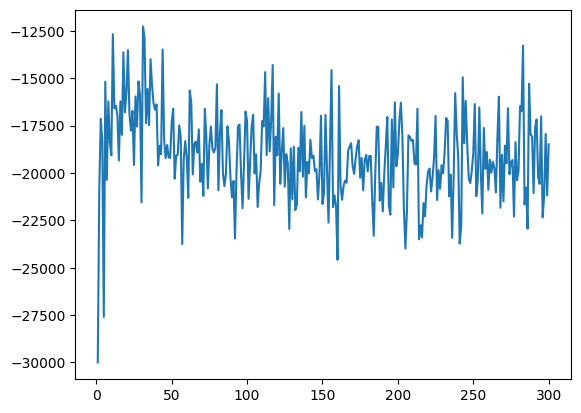

In [79]:
plt.plot(np.arange(1, n_episode + 1), total_reward_episode)
plt.show()